In [1]:
%matplotlib inline

# Подключаем необходимые библиотеки:
# Библиотеки для запуска сервера:
from flask import Flask, request, jsonify, Response, redirect, flash, make_response
from flask import render_template, url_for
from flask_cors import CORS, cross_origin

# Библиотеки для работы с хранилищем sentinel-hub:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
import sentinelhub
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataCollection, bbox_to_dimensions, geo_utils

# Библиотеки для работы с графикой, числовыми матрицами и математического анализа:
import matplotlib.pyplot as plt
from matplotlib import cm
import io
import base64
from base64 import encodebytes
import os
import PIL.Image as Image
import numpy as np
from numpyencoder import NumpyEncoder
import pandas as pd
import math
import cv2
from scipy.signal import argrelextrema, resample
from scipy import interpolate

# Библиотека для работы с форматом Json:
import json

# Библиотека для преобразования географических координат в метрические:
from pyproj import Proj, transform
# Убираем warning бтблиотеки pyproj:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Принимаем запрос на обработку:

request_data = {'download_data': 'exist', 'name_sputnik': 'sentinel-2', 'type_relief': '0', 'contour_line_width': '1', 'sensitivity': '20', 'image_B02': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCABAAEABAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AOCTCgnOM8U8yFsKhOR7VMMghM5I6mpRVe8uBbWzyn+GuI1O8a7k+Y8A8CnaNai6vCG+4q5NdVbpFbr5aHAznFSN0B9B0p0ZUHJGTnrT/tEUT4ZwCx6VKJkbowrH8SXHl2AUH7xrjlDO3GSa3tEjaKOSRuNwwK1Yw0gJz+NTgsx6nFLLKbW3aZl4HauVnv5HuC4JznirNrc3UsjbNxBHJo1ozXDxqFZsL6Vb0nTRBH5siZf0Naptc4JG0Y+6OtWIoREgHCc/jUMfzHJBwKdew/abBkPbnA9qrppFj5Qcx8Fc806KKMDZAm2pRZ7jtc5I7LVpIUiQ5bHsP8aGkAXagAqvtw+4nn3qJJQB8vPpVqE9j0PU+lPKDyxFyewxQEjjHPHstBl+XC4Ue1Qs52e5PJoDhmGKYZR7A+9WEtYxwpWn7Ejx5rgj+6tK9wudmQvoBWfK5WU45B5+lTD+8Tmk4BJx3prHBxjtVbOT6nOBmpWlOWwT07UxpdoDbuAPrTLaOa9nLDITPWr89iXdGQ5Ofmpj280Scjd3+WoRMEkCtnJ9qklIGcenSodoVxjjj0quJCWAANDuCANv4Ctq0jWOEbD1H5U+SQpjH3icYqQDaM55NNeKOUEMo+tZ00BgmGTlD0NQsw3HAr//2Q==', 'image_B03': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCABAAEABAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APPkAUHn2p5cnCqTmpQSCFzk9zUlQ3UwggaQ9q47VLr7SeT34FN0i2Fzd4b7ijJrqLeOOBCiH3xUp6Aj8qdGVHJHOe1O86ONvmYAk9KkEqsOorL1+48qx6/eNcflpHJ5Jrc0WNo0kkbjIwDWom51Jz+NWAWJ6nFLI5t4TKw4Fc3caiTOSCc5qa2vLiSQhNxGOTTdaaWfy1Cs2B6VY0rTRCnmyrl/Q1q/ZuQcBRj7oHNWIohEgHC8/jUSfN2OBTryI3FkyenPFVU0iy8sOUJBGafFDGg2QJtqUWm44bnHYVZSJY05OPYf40rSDbhQBVfBDZJqNJAB8vIqzEecHoepNO2DYIzk+mKFRIx6ewoMnykLhR7VEznb7k0BgSMdaaZB7Z96nW2Qfd207aqY3sMf3VpWmX7mQvoBVGWQrI2DkHpUo9T/APqpOAScUjHB6VXzlvU5wM1I0py2CenamtJgKd2Rj61HAst5OWGQoPWrs1mzOrIc+tNeGaNDkbh14qIShXCtnn1qSQ46flUO0K4xxxUAfJAwRSs4KgbfwrVtY1jiG08EdKldyuMdSelOAIHU5NNeKOQYZR9aoywmGUEnKnpUTMNxx+Ff/9k=', 'image_B04': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCABAAEABAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AODQBQTn2p5kJwqnkVMCRhc5Pc1JUNxKIYmc9q47WrkXA5PIPFVtHtftN5hvuKMmutto0t08tW461Kw4B9O1OjKjkjmpRKiN8zAEnpUgkU96yteuRBYnnqa4lneV8nJNbuhRtGskhGMjANa8e6QE5/GrGXY9TinM/kRGVhwK5651UCY4OWz2qS31GeSQqgY5HUdqi12R5xGgDNgelS6RpgiTzpU+b0IrZFp0OAq+mKsxQrEgHC/zqFPm7HAp17CbixdMkdziqaaJY+WHKEgj1qSGCKMbIEC1MLLeQH5I9OatJCkSdfwH+NK0g24UAVBghsk/gahSUAfKcirUR/hPQ9SafsAjEfJ9MUKkcft7CgycYXCioWc7evJNAcMRimGQfj71YW1jHC4p+1EADsPoKVpl+7kD0FUJZCspxyD0qYY5LHjtTeATTWPPTH0qsDuPrzgZqVpSC2CenamtLjDbs8fWmQCa8nJXIQHrV2eyZnVkOfX/ABpjwzRJ8wyBzxUYmCuFbvT5Tjp37VDtCuMccVX8zLdCPpSu4KhduPbNa9pEsUK7DwR+VSvIVAx1PangY71HJDHKPmUZ9RVGSIwyjJ+U9DUTMNzYr//Z'}
#rs = r.json()
#request_data = r
data_dn = request_data['download_data']
print(data_dn)
name_sputnik = request_data['name_sputnik']
type_relief = int(request_data['type_relief'])
sensitivity = int(request_data['sensitivity'])
contour_line_width = int(request_data['contour_line_width'])
# Берем из запроса основные параметры обработки:

# Если изображения хранятся в запросе:
if data_dn == 'exist':
    #Если спутник Sentinel-2:
    if name_sputnik == 'sentinel-2':
        # Берем из запроса изображения:
        imgbytesB02 = base64.b64decode(request_data['image_B02'])
        imgB02 = Image.open(io.BytesIO(imgbytesB02))
        B02 = np.asarray(imgB02)
        imgbytesB03 = base64.b64decode(request_data['image_B03'])
        imgB03 = Image.open(io.BytesIO(imgbytesB03))
        B03 = np.asarray(imgB03)
        imgbytesB04 = base64.b64decode(request_data['image_B04'])
        imgB04 = Image.open(io.BytesIO(imgbytesB04))
        B04 = np.asarray(imgB04)

exist


In [3]:
def HighlightCompressVisualizer(val,minA,maxA):
    cs = (val-minA)/(maxA-minA)
    if val <= minA:
        return 0
    elif val > minA and cs <= 0.92:
        return cs
    elif val <= 0.9:
        return (0.08*(val-cs))/(0.9-cs)+0.92
    else:
        return val

In [4]:
def analysis_data_sentinel_2(B02, B03, B04, type_relief,sensitivity):
    print('Start analysis Sentinel-2')
    # Создаем пустое изображение:
    # Создаем цветовую палитру по имени:
    cm2 = plt.get_cmap('gist_rainbow')
    # Применяем цветовую палитру к массиву:
    colored_image = cm2(B02)
    # Полученную картинку с 4-мя каналами (R,G,B,A) с значениями float[0, 1] конвертируем в RGB(uint8):
    imgcc = Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8))
    imgTrueColor = np.asarray(imgcc)

    # Из массивов B02, B03 и B04 делаем осветлённое TrueColor изображение:
    img = np.zeros((B02.shape[0], B02.shape[1], 3))
    img[:,:,0] = B02/50
    img[:,:,1] = B03/50
    img[:,:,2] = B04/50

    # Из массивов B02, B03 и B04 делаем обычное TrueColor изображение:
    img2 = np.zeros((B02.shape[0], B02.shape[1], 3))
    img2[:,:,0] = B02
    img2[:,:,1] = B03
    img2[:,:,2] = B04
    #cv2.imwrite('Color_(B02,B03,B04).jpg',img2)

    # Создаем массивы данных для создания HighLight-изображения:
    height, width, _ = img.shape
    minC0 = np.full((height, width), 0.2)
    maxC0 = np.full((height, width), 0.5)
    minC1 = np.full((height, width), 0.2)
    maxC1 = np.full((height, width), 0.5)
    minC2 = np.full((height, width), 0.001)
    maxC2 = np.full((height, width), 0.98)
    
    # Создаем HighLight-изображение:
    imgTrueColor[:,:,0] = np.array(np.vectorize(HighlightCompressVisualizer)(list(map(lambda x,y: x*y,B02,np.full(B02.size,4/256))),minC0,maxC0)*256,dtype=np.uint8)
    imgTrueColor[:,:,1] = np.array(np.vectorize(HighlightCompressVisualizer)(list(map(lambda x,y: x*y,B03,np.full(B03.size,4/256))),minC1,maxC1)*256,dtype=np.uint8)
    imgTrueColor[:,:,2] = np.array(np.vectorize(HighlightCompressVisualizer)(list(map(lambda x,y: x*y,B04,np.full(B04.size,2/256))),minC2,maxC2)*256,dtype=np.uint8)

    if type_relief == 1:
        # Определяем границы Фильтра диапазона красного цвета:
        # Преобразуем массив пикселей в картинку формата Jpeg:
        imgTrueColor_rgb = cv2.cvtColor(np.uint8(imgTrueColor), cv2.COLOR_BGR2RGB)
        pil_imgTrueColor = Image.fromarray(imgTrueColor_rgb)
        b = io.BytesIO()
        pil_imgTrueColor.save(b, 'jpeg')
        pil_imgTrueColor_bytes = b.getvalue()
        str_imgTrueColor = str(base64.b64encode(pil_imgTrueColor_bytes), encoding='utf-8')#.decode('utf-8')
        hightlight_image = Image.open(io.BytesIO(base64.b64decode(str_imgTrueColor)))
        img3 = np.asarray(hightlight_image)
        #img3 = cv2.cvtColor(np.uint8(img3), cv2.COLOR_BGR2RGB)
        # Строим гистограмму красного канала:
        hi0, countshi2 = np.histogram(img3[:, :, 0], range(256))#img3[:, :, 0].ravel()
        # Строим гистограмму красного канала:
        hi1, countshi1 = np.histogram(img3[:, :, 1], range(256))#hi1 = img3[:, :, 1].ravel()

        window_len = 2
        while True:
            # Сглаживаем графики гистограм:
            window_len += 1
            kernel = np.ones(window_len, dtype=float)/window_len
            smooth_hi0 = np.convolve(hi0, kernel, 'same')
            # Ищем минимумы сглаженных графиков гистограм:
            minHi0 = np.array(argrelextrema(smooth_hi0, np.less)[0])
            if minHi0.size <= 2:
                break
        if len(minHi0) < 2:
            minHi0 = np. concatenate( (minHi0, [245] ) )
        if minHi0[1] < 200:
            minHi0[1] = 245
        print(minHi0)

        window_len = 2
        while True:
            # Сглаживаем графики гистограм:
            window_len += 1
            kernel = np.ones(window_len, dtype=float)/window_len
            smooth_hi1 = np.convolve(hi1, kernel, 'same')
            # Ищем минимумы сглаженных графиков гистограм:
            minHi1 = np.array(argrelextrema(smooth_hi1, np.less)[0])
            if minHi1.size <= 5:
                break
        print(minHi1)

        # Пропускаем изображение через Фильтр диапазона красного цвета:
        hsv_min = np.array((0, 0, minHi0[0]), np.uint8) #23
        hsv_max = np.array((0, 0, minHi0[1]), np.uint8) #223
        thresh1 = cv2.inRange(imgTrueColor, hsv_min, hsv_max)

        # Пропускаем изображение через Фильтр диапазона красно-зеленого цвета:
        hsv_min = np.array((0, minHi0[0], minHi0[0]), np.uint8) #23
        hsv_max = np.array((0, minHi1[0], minHi1[0]), np.uint8) #50
        thresh2 = cv2.inRange(imgTrueColor, hsv_min, hsv_max)

        #thresh = thresh1 + thresh2

        # Размываем, чтобы убрать шум:
        #threshTrue_blur = cv2.bilateralFilter(threshTrue, d = 140, sigmaSpace = 75, sigmaColor = 75)# Convert to grayscale
        thresh1 = cv2.medianBlur(thresh1,3)
        thresh1 = cv2.medianBlur(thresh1,3)
        thresh1 = cv2.medianBlur(thresh1,3)

        thresh2 = cv2.medianBlur(thresh2,3)
        thresh2 = cv2.medianBlur(thresh2,3)
        thresh2 = cv2.medianBlur(thresh2,3)
    elif type_relief == 0:
        gray = cv2.cvtColor(imgTrueColor, cv2.COLOR_BGR2GRAY)

        # Пропускаем изображение через пороговую функцию:
        ret, thresh1 = cv2.threshold(gray, sensitivity, 255, cv2.THRESH_BINARY_INV)
        thresh2 = []
    
    # Возвращаем результрат пропуска изображения через фильтр диапазона красного цвета:
    print('End analysis Sentinel-2')
    return thresh1, thresh2, img2, imgTrueColor


In [5]:
thresh, thresh2, img, imgTrueColor = analysis_data_sentinel_2(B02, B03, B04, type_relief, sensitivity)

Start analysis Sentinel-2
End analysis Sentinel-2


In [6]:
# Ищем контуры:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# Сортируем найденные контуры по убыванию их длин:
contours = sorted(contours, key = cv2.contourArea, reverse=True)
# Составляем список 30 самых длиных контуров:
cnt = []
if len(contours) > 0:
    if len(contours) >= 30:
        for i in range(30):
            cnt.append(contours[i])
    else:
        for i in range(len(contours)):
            cnt.append(contours[i])
    img2 = img.copy()

    # Накладываем контуры на TrueColor изображение:
    resImg = cv2.drawContours(img, cnt, -1, (0, 0, 255), contour_line_width)

    cnt2 = []
    cntList2 = []

    if name_sputnik == 'sentinel-2' and len(thresh2) > 0:
        # Ищем контуры:
        contours2, hierarchy2 = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # Сортируем найденные контуры по убыванию их длин:
        contours2 = sorted(contours2, key = cv2.contourArea, reverse=True)
        # Составляем список 30 самых длиных контуров:
        if len(contours2) >= 30:
            for i in range(30):
                cnt2.append(contours2[i])
        else:
            for i in range(len(contours2)):
                cnt2.append(contours2[i])
        # Накладываем контуры на TrueColor изображение:
        resImg = cv2.drawContours(resImg, cnt2, -1, (0, 255, 255), contour_line_width)

        # Получаем список контуров в виде списков узловых точек каждого контура:
        cntList2 = json.dumps(cnt2,cls=NumpyEncoder)

    # Получаем список контуров в виде списков узловых точек каждого контура:
    cntList = json.dumps(cnt,cls=NumpyEncoder)

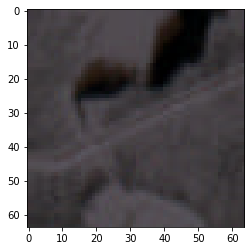

In [7]:
if len(contours) > 0:
    # Превращаем цветную картинку в список для передачи через json:
    img2_rgb = cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB)
    pil_img2 = Image.fromarray(img2_rgb)
    b = io.BytesIO()
    pil_img2.save(b, 'jpeg')
    pil_img2_bytes = b.getvalue()
    str_img2 = str(base64.b64encode(pil_img2_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_img2)
    plt.axis("on")
    plt.show()

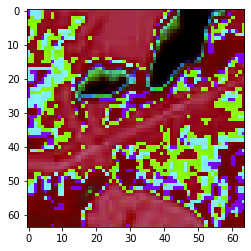

In [8]:
if len(contours) > 0:
    # Превращаем цветную HightLight картинку в список для передачи через json:
    imgTrueColor_rgb = cv2.cvtColor(np.uint8(imgTrueColor), cv2.COLOR_BGR2RGB)
    pil_imgTrueColor = Image.fromarray(imgTrueColor_rgb)
    b = io.BytesIO()
    pil_imgTrueColor.save(b, 'jpeg')
    pil_imgTrueColor_bytes = b.getvalue()
    str_imgTrueColor = str(base64.b64encode(pil_imgTrueColor_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_imgTrueColor)
    plt.axis("on")
    plt.show()

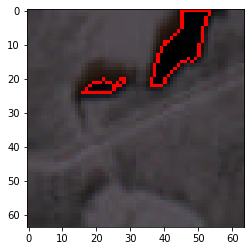

In [9]:
if len(contours) > 0:
    # Превращаем цветную картинку с нанесенными контурами в список для передачи через json:
    resImg_rgb = cv2.cvtColor(np.uint8(resImg), cv2.COLOR_BGR2RGB)
    pil_resImg_rgb = Image.fromarray(resImg_rgb)
    b = io.BytesIO()
    pil_resImg_rgb.save(b, 'jpeg')
    pil_resImg_rgb_bytes = b.getvalue()
    str_resImg_rgb = str(base64.b64encode(pil_resImg_rgb_bytes), encoding='utf-8')#.decode('utf-8')
    plt.imshow(pil_resImg_rgb)
    plt.axis("on")
    plt.show()

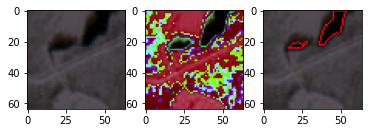

In [10]:
# Построим все три картинки вместе:
if len(contours) > 0:
    # Превращаем цветную картинку в список для передачи через json:
    img2_rgb = cv2.cvtColor(np.uint8(img2), cv2.COLOR_BGR2RGB)
    pil_img2 = Image.fromarray(img2_rgb)
    b = io.BytesIO()
    pil_img2.save(b, 'jpeg')
    pil_img2_bytes = b.getvalue()
    str_img2 = str(base64.b64encode(pil_img2_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Превращаем цветную HightLight картинку в список для передачи через json:
    imgTrueColor_rgb = cv2.cvtColor(np.uint8(imgTrueColor), cv2.COLOR_BGR2RGB)
    pil_imgTrueColor = Image.fromarray(imgTrueColor_rgb)
    b = io.BytesIO()
    pil_imgTrueColor.save(b, 'jpeg')
    pil_imgTrueColor_bytes = b.getvalue()
    str_imgTrueColor = str(base64.b64encode(pil_imgTrueColor_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Превращаем цветную картинку с нанесенными контурами в список для передачи через json:
    resImg_rgb = cv2.cvtColor(np.uint8(resImg), cv2.COLOR_BGR2RGB)
    pil_resImg_rgb = Image.fromarray(resImg_rgb)
    b = io.BytesIO()
    pil_resImg_rgb.save(b, 'jpeg')
    pil_resImg_rgb_bytes = b.getvalue()
    str_resImg_rgb = str(base64.b64encode(pil_resImg_rgb_bytes), encoding='utf-8')#.decode('utf-8')
    
    # Выводим на экран все три картинки:
    plt.subplot(1,3,1)
    plt.imshow(pil_img2)
    plt.subplot(1,3,2)
    plt.imshow(pil_imgTrueColor)
    plt.subplot(1,3,3)
    plt.imshow(pil_resImg_rgb)
    plt.axis("on")
    plt.show()